# Symbolic Regression through Genetic Programming 
## Importing relevant packages

In [1]:
import math, random, operator
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from deap import algorithms, base, creator, tools, gp

## Data Prep
### Pulling Data In

In [2]:
data1 = pd.read_csv("data1.csv")
data2 = pd.read_csv("data2.csv")

### Splitting Data

In [3]:
train1, test1 = train_test_split(data1, test_size=0.2, shuffle=True)
train2, test2 = train_test_split(data2, test_size=0.2, shuffle=True)

## Defining Operations

In [4]:
def protectedDiv(left, right):
    try:
        return left / right
    except ZeroDivisionError:
        return 1
def create_pset(data_set):
    n_var = len(data_set.columns) - 1
    pset = gp.PrimitiveSet("MAIN", n_var)
    pset.addPrimitive(operator.add, 2)
    pset.addPrimitive(operator.sub, 2)
    pset.addPrimitive(operator.mul, 2)
    pset.addPrimitive(protectedDiv, 2)
    pset.addPrimitive(operator.neg, 1)
    pset.addPrimitive(math.cos, 1)
    pset.addPrimitive(math.sin, 1)    
    pset.addEphemeralConstant("rand1", lambda: random.randint(-1,1))
    return pset
pset = create_pset(test1)

## Fitness Function

In [5]:
def evalSymbReg(individual, points):
    # Transform the tree expression in a callable function
    func = toolbox.compile(expr=individual)
    y_set = points['y'].to_numpy()
    x_set = points[points.columns.difference(['y'])].to_numpy()

    # Evaluate the mean squared error between the expression
    # and the real function : x**4 + x**3 + x**2 + x
    sqerrors = ((func(*x.tolist()) - y)**2 for x,y in zip(x_set, y_set))
    return math.fsum(sqerrors) / len(points),

## Configuring our GP

In [24]:
## Fitness function
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

toolbox.register("evaluate", evalSymbReg, points = data1)

#deap.tools.selDoubleTournament(individuals, k, fitness_size, parsimony_size, fitness_first, fit_attr='fitness')
#toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("select", tools.selDoubleTournament, fitness_size=3, parsimony_size=1.4, fitness_first=False)

toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
#mstats.register("std", np.std)
mstats.register("min", np.min)
#mstats.register("max", np.max)

pop, log = algorithms.eaSimple(pop, toolbox, 0.8, 0.1, 2000, stats=mstats,
                               halloffame=hof, verbose=True)
# print log

C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


   	      	                   fitness                    	             size             
   	      	----------------------------------------------	------------------------------
gen	nevals	avg       	gen	min       	nevals	avg    	gen	min	nevals
0  	300   	7.4945e+09	0  	3.4732e+09	300   	3.74667	0  	2  	300   
1  	238   	1.19039e+11	1  	1.00502e+09	238   	3.59   	1  	1  	238   
2  	250   	7.08804e+09	2  	9.9622e+08 	250   	3.68   	2  	1  	250   
3  	256   	1.18429e+11	3  	9.9622e+08 	256   	3.63667	3  	1  	256   
4  	251   	5.69304e+09	4  	9.9622e+08 	251   	3.59333	4  	1  	251   
5  	224   	4.25324e+09	5  	1.53255e+07	224   	3.62   	5  	1  	224   
6  	241   	4.51853e+11	6  	1.53255e+07	241   	3.88667	6  	1  	241   
7  	244   	2.26909e+11	7  	1.53255e+07	244   	4.35   	7  	1  	244   
8  	234   	5.75046e+11	8  	1.42633e+07	234   	5.00667	8  	1  	234   
9  	248   	5.86599e+11	9  	1.22626e+07	248   	5.64333	9  	1  	248   
10 	251   	1.70491e+09	10 	1.22626e+07	251   	6.16   	10 	1  	251  

116	238   	1.03351e+12	116	1.06133e+06	238   	76.7567	116	9  	238   
117	240   	1.49485e+09	117	1.06133e+06	240   	75.6133	117	2  	240   
118	256   	3.91504e+09	118	1.05983e+06	256   	77.4167	118	1  	256   
119	262   	1.03476e+12	119	1.05983e+06	262   	75.2467	119	9  	262   
120	250   	1.16428e+11	120	1.05983e+06	250   	73.6133	120	9  	250   
121	256   	5.96634e+08	121	1.05983e+06	256   	74.96  	121	13 	256   
122	265   	2.45572e+09	122	1.06058e+06	265   	74.05  	122	1  	265   
123	257   	9.64174e+09	123	1.06058e+06	257   	74.57  	123	3  	257   
124	255   	9.61892e+08	124	1.05983e+06	255   	74.1467	124	2  	255   
125	249   	2.0262e+09 	125	1.05105e+06	249   	74.24  	125	9  	249   
126	247   	1.85027e+08	126	1.05105e+06	247   	73.22  	126	9  	247   
127	250   	1.74344e+09	127	1.05105e+06	250   	71.7233	127	7  	250   
128	247   	2.35086e+09	128	1.05107e+06	247   	72.2933	128	9  	247   
129	243   	3.90356e+09	129	1.05107e+06	243   	72.0867	129	13 	243   
130	257   	1.58244e+10	130	1.05043

235	254   	1.03494e+12	235	1.04874e+06	254   	68.6667	235	5  	254   
236	252   	9.29925e+12	236	1.04797e+06	252   	68.6   	236	9  	252   
237	243   	9.30464e+12	237	1.04874e+06	243   	69.2033	237	2  	243   
238	248   	5.76042e+11	238	1.04874e+06	248   	68.95  	238	3  	248   
239	253   	1.66725e+09	239	1.02577e+06	253   	70.1433	239	1  	253   
240	254   	7.05676e+09	240	1.02577e+06	254   	69.4533	240	9  	254   
241	231   	1.04845e+12	241	1.02577e+06	231   	71.35  	241	9  	231   
242	225   	1.14683e+12	242	1.02577e+06	225   	71.0533	242	9  	225   
243	253   	1.03577e+12	243	1.02577e+06	253   	72.2433	243	9  	253   
244	233   	1.27755e+10	244	1.02577e+06	233   	72.7367	244	9  	233   
245	232   	7.24672e+08	245	1.00915e+06	232   	71.4   	245	9  	232   
246	235   	9.75912e+12	246	1.00915e+06	235   	72.0133	246	1  	235   
247	256   	9.20535e+09	247	1.00915e+06	256   	70.1633	247	9  	256   
248	250   	5.6973e+15 	248	1.00995e+06	250   	69.5833	248	1  	250   
249	243   	1.44244e+09	249	1.00915

354	246   	7.17309e+09	354	991340     	246   	85.0367	354	9  	246   
355	254   	1.85931e+09	355	991340     	254   	85.08  	355	9  	254   
356	262   	1.67405e+09	356	991340     	262   	85.9833	356	9  	262   
357	253   	1.1825e+09 	357	991340     	253   	85.5833	357	4  	253   
358	236   	9.43962e+08	358	992164     	236   	85.68  	358	12 	236   
359	230   	4.14759e+12	359	992164     	230   	84.3833	359	3  	230   
360	255   	3.87805e+09	360	992164     	255   	84.88  	360	7  	255   
361	242   	1.18622e+09	361	991340     	242   	83.3833	361	9  	242   
362	235   	1.01228e+09	362	992990     	235   	83.4833	362	9  	235   
363	240   	5.8857e+08 	363	992990     	240   	83.5067	363	9  	240   
364	264   	1.03099e+12	364	992981     	264   	83.92  	364	9  	264   
365	252   	6.84636e+09	365	992164     	252   	82.4867	365	1  	252   
366	238   	1.04156e+09	366	992164     	238   	82.8167	366	9  	238   
367	239   	2.08361e+09	367	992164     	239   	83.67  	367	9  	239   
368	246   	1.04839e+12	368	992164 

473	240   	5.40786e+08	473	988770     	240   	81.6667	473	2  	240   
474	232   	1.62942e+11	474	988770     	232   	83.48  	474	3  	232   
475	247   	3.26494e+08	475	988770     	247   	82.7667	475	1  	247   
476	250   	7.33062e+08	476	988770     	250   	84.6133	476	1  	250   
477	237   	8.06484e+08	477	984520     	237   	84.9067	477	9  	237   
478	240   	1.15249e+11	478	984520     	240   	81.9767	478	9  	240   
479	245   	2.09756e+10	479	984520     	245   	83.0333	479	9  	245   
480	255   	1.03239e+12	480	984520     	255   	84.75  	480	9  	255   
481	246   	1.38137e+09	481	984520     	246   	84.5667	481	11 	246   
482	237   	6.6433e+08 	482	988716     	237   	82.7333	482	1  	237   
483	247   	3.85413e+08	483	988020     	247   	82.4267	483	1  	247   
484	252   	6.46324e+09	484	988770     	252   	83.4367	484	17 	252   
485	237   	1.54729e+09	485	986937     	237   	81.5033	485	4  	237   
486	246   	2.53276e+09	486	986937     	246   	83.3033	486	9  	246   
487	246   	1.03118e+12	487	988074 

592	256   	1.03071e+12	592	984906     	256   	84.7367	592	3  	256   
593	263   	4.00814e+08	593	985480     	263   	85.05  	593	9  	263   
594	241   	9.55766e+08	594	983915     	241   	86.7767	594	9  	241   
595	234   	1.04297e+12	595	985480     	234   	86.1133	595	3  	234   
596	251   	9.70177e+09	596	985628     	251   	85.99  	596	7  	251   
597	249   	5.56544e+09	597	984906     	249   	85.7267	597	9  	249   
598	253   	9.84693e+09	598	984051     	253   	85.7133	598	9  	253   
599	234   	2.28131e+09	599	984051     	234   	86.49  	599	10 	234   
600	246   	1.01126e+10	600	984051     	246   	85.1933	600	1  	246   
601	242   	8.84294e+08	601	984051     	242   	86.5533	601	1  	242   
602	257   	4.98123e+08	602	975332     	257   	86.41  	602	9  	257   
603	257   	1.04382e+12	603	974548     	257   	86.4   	603	11 	257   
604	264   	2.67746e+09	604	974394     	264   	83.9767	604	9  	264   
605	242   	2.79367e+09	605	974394     	242   	85.5433	605	4  	242   
606	248   	1.03647e+12	606	984770 

711	256   	3.26858e+09	711	950823     	256   	87.8767	711	9  	256   
712	246   	9.68245e+08	712	950823     	246   	88.8733	712	11 	246   
713	246   	1.54881e+10	713	951334     	246   	87.4233	713	11 	246   
714	244   	1.59606e+10	714	950790     	244   	88.2567	714	11 	244   
715	243   	9.3298e+12 	715	950790     	243   	86.7   	715	1  	243   
716	256   	1.17192e+12	716	950790     	256   	87.9967	716	9  	256   
717	238   	1.48707e+10	717	951192     	238   	90.4467	717	3  	238   
718	235   	1.18283e+11	718	950414     	235   	90.57  	718	12 	235   
719	245   	1.49479e+12	719	932015     	245   	89.0767	719	21 	245   
720	259   	2.61063e+09	720	932015     	259   	88.63  	720	14 	259   
721	238   	1.03728e+13	721	932015     	238   	89.2667	721	16 	238   
722	265   	2.57676e+09	722	935712     	265   	88.87  	722	3  	265   
723	250   	4.95506e+09	723	935712     	250   	88.9667	723	16 	250   
724	235   	9.29912e+12	724	896920     	235   	90.9033	724	9  	235   
725	242   	8.2276e+08 	725	896920 

830	232   	1.44664e+09	830	935813     	232   	95.06  	830	3  	232   
831	262   	9.33218e+12	831	935813     	262   	94.6467	831	16 	262   
832	248   	3.11315e+09	832	926966     	248   	94.0667	832	18 	248   
833	248   	2.63027e+10	833	926966     	248   	94.97  	833	13 	248   
834	238   	6.61497e+08	834	926966     	238   	95.44  	834	18 	238   
835	241   	1.21128e+11	835	926966     	241   	94.8067	835	8  	241   
836	261   	1.63802e+10	836	926966     	261   	95.4467	836	2  	261   
837	244   	2.07576e+12	837	926966     	244   	97.1267	837	2  	244   
838	227   	5.17319e+16	838	926508     	227   	96.9533	838	18 	227   
839	247   	1.47481e+10	839	926508     	247   	96.9033	839	16 	247   
840	238   	1.04638e+12	840	926508     	238   	97.2033	840	18 	238   
841	247   	6.30027e+08	841	926508     	247   	97.14  	841	16 	247   
842	253   	1.03947e+09	842	925643     	253   	98.1967	842	18 	253   
843	238   	1.0395e+12 	843	926390     	238   	97.43  	843	18 	238   
844	260   	1.03125e+12	844	926390 

949	237   	1.0378e+12 	949	909100     	237   	106.27 	949	16 	237   
950	251   	2.78589e+09	950	924692     	251   	106.993	950	26 	251   
951	246   	4.41957e+09	951	924692     	246   	107.043	951	24 	246   
952	245   	2.1626e+08 	952	919950     	245   	107.897	952	45 	245   
953	248   	1.04808e+10	953	924692     	248   	107.133	953	34 	248   
954	254   	1.04033e+12	954	921183     	254   	106.447	954	26 	254   
955	262   	2.79497e+09	955	919476     	262   	107.327	955	1  	262   
956	240   	3.14507e+09	956	919476     	240   	107.94 	956	26 	240   
957	254   	1.24867e+11	957	915326     	254   	106.483	957	22 	254   
958	228   	1.04654e+12	958	915326     	228   	107.163	958	25 	228   
959	244   	1.20614e+08	959	915326     	244   	107.54 	959	26 	244   
960	232   	8.85477e+09	960	913946     	232   	108.667	960	55 	232   
961	247   	1.03889e+12	961	913875     	247   	106.853	961	17 	247   
962	268   	6.88619e+08	962	913946     	268   	108.167	962	26 	268   
963	254   	1.09026e+12	963	913946 

1065	240   	1.15951e+09	1065	920057     	240   	106.857	1065	6  	240   
1066	250   	1.14855e+11	1066	919974     	250   	107.183	1066	31 	250   
1067	251   	1.83349e+09	1067	919974     	251   	106.353	1067	1  	251   
1068	230   	9.25851e+09	1068	918115     	230   	107.237	1068	24 	230   
1069	261   	2.27869e+16	1069	914089     	261   	107.17 	1069	30 	261   
1070	246   	1.15479e+12	1070	914089     	246   	107.12 	1070	1  	246   
1071	247   	4.64153e+08	1071	913640     	247   	108.593	1071	38 	247   
1072	263   	2.37779e+09	1072	913640     	263   	107.863	1072	38 	263   
1073	246   	8.00866e+09	1073	913640     	246   	108.52 	1073	19 	246   
1074	236   	1.14053e+11	1074	913640     	236   	108.2  	1074	48 	236   
1075	247   	1.28329e+09	1075	913640     	247   	107.003	1075	29 	247   
1076	250   	1.28393e+09	1076	912818     	250   	107.893	1076	29 	250   
1077	238   	9.57527e+09	1077	904174     	238   	107.473	1077	20 	238   
1078	238   	1.03246e+12	1078	904174     	238   	109.053	1078	55 

1179	237   	1.54185e+09	1179	929851     	237   	101.587	1179	1  	237   
1180	250   	1.0407e+12 	1180	920547     	250   	100.27 	1180	26 	250   
1181	238   	3.56203e+08	1181	930234     	238   	100.033	1181	22 	238   
1182	242   	6.09186e+08	1182	930234     	242   	102.037	1182	32 	242   
1183	248   	2.72191e+09	1183	930234     	248   	101.093	1183	4  	248   
1184	243   	4.99196e+09	1184	930234     	243   	101.56 	1184	35 	243   
1185	238   	1.13616e+11	1185	930234     	238   	101.813	1185	26 	238   
1186	250   	1.11077e+12	1186	929876     	250   	100.737	1186	26 	250   
1187	252   	1.34198e+09	1187	930234     	252   	99.2467	1187	26 	252   
1188	254   	3.88946e+09	1188	930259     	254   	99.77  	1188	1  	254   
1189	244   	9.29388e+12	1189	930259     	244   	101.74 	1189	26 	244   
1190	246   	1.07231e+10	1190	930259     	246   	101.187	1190	35 	246   
1191	257   	1.03322e+12	1191	923978     	257   	100.557	1191	28 	257   
1192	256   	9.52213e+08	1192	930259     	256   	100.61 	1192	24 

1293	258   	2.07125e+12	1293	887089     	258   	103.537	1293	1  	258   
1294	258   	2.06495e+09	1294	887089     	258   	104.567	1294	35 	258   
1295	259   	1.25085e+11	1295	887089     	259   	103.72 	1295	26 	259   
1296	244   	5.46825e+09	1296	887089     	244   	104.29 	1296	4  	244   
1297	240   	1.14726e+12	1297	887089     	240   	103.863	1297	25 	240   
1298	241   	2.03344e+09	1298	898752     	241   	104.477	1298	26 	241   
1299	247   	1.03912e+12	1299	912614     	247   	103.783	1299	1  	247   
1300	243   	1.22025e+10	1300	912614     	243   	105.747	1300	29 	243   
1301	250   	1.24948e+09	1301	916915     	250   	104.767	1301	26 	250   
1302	242   	4.9771e+09 	1302	916915     	242   	104.903	1302	26 	242   
1303	258   	1.17377e+11	1303	916915     	258   	104.98 	1303	27 	258   
1304	241   	1.04289e+12	1304	916915     	241   	103.813	1304	8  	241   
1305	247   	2.44978e+09	1305	883939     	247   	105.233	1305	41 	247   
1306	245   	4.14211e+12	1306	923107     	245   	104.927	1306	42 

1407	240   	2.09352e+09	1407	915326     	240   	105.03 	1407	32 	240   
1408	247   	1.38778e+10	1408	915326     	247   	104.97 	1408	28 	247   
1409	245   	1.04275e+12	1409	899579     	245   	104.8  	1409	7  	245   
1410	269   	4.98561e+09	1410	910591     	269   	103.507	1410	32 	269   
1411	244   	1.03633e+12	1411	910591     	244   	105.107	1411	1  	244   
1412	230   	1.02225e+10	1412	910591     	230   	104.493	1412	36 	230   
1413	244   	1.03745e+12	1413	910591     	244   	104.283	1413	25 	244   
1414	254   	5.95885e+08	1414	910591     	254   	104.577	1414	33 	254   
1415	238   	2.06307e+12	1415	910591     	238   	104.78 	1415	34 	238   
1416	243   	1.4559e+09 	1416	897191     	243   	104.473	1416	28 	243   
1417	252   	3.98151e+08	1417	899579     	252   	104.033	1417	1  	252   
1418	245   	1.17206e+11	1418	899579     	245   	104.84 	1418	20 	245   
1419	251   	1.04731e+12	1419	906758     	251   	107.507	1419	47 	251   
1420	245   	3.1651e+09 	1420	906647     	245   	106.047	1420	16 

1522	254   	1.62475e+09	1522	867474     	254   	125.317	1522	1  	254   
1523	250   	1.36122e+12	1523	867474     	250   	124.873	1523	3  	250   
1524	246   	1.14073e+11	1524	867474     	246   	127.403	1524	63 	246   
1525	257   	1.04819e+12	1525	867474     	257   	125.157	1525	2  	257   
1526	237   	2.2635e+09 	1526	867474     	237   	125.223	1526	55 	237   
1527	238   	9.33089e+08	1527	864584     	238   	124.597	1527	41 	238   
1528	233   	9.33885e+12	1528	863464     	233   	125.747	1528	39 	233   
1529	257   	1.15926e+11	1529	862135     	257   	125.423	1529	3  	257   
1530	250   	1.03943e+12	1530	861787     	250   	125.593	1530	39 	250   
1531	232   	1.52121e+09	1531	861787     	232   	127.123	1531	56 	232   
1532	243   	2.61091e+08	1532	861787     	243   	126.463	1532	42 	243   
1533	234   	7.82495e+09	1533	861787     	234   	128.017	1533	79 	234   
1534	254   	9.7065e+09 	1534	861787     	254   	127.21 	1534	1  	254   
1535	262   	1.14904e+12	1535	861787     	262   	126.583	1535	46 

1636	245   	1.19988e+11	1636	865405     	245   	124.837	1636	44 	245   
1637	234   	1.08054e+10	1637	865405     	234   	125.097	1637	55 	234   
1638	246   	4.86779e+09	1638	858213     	246   	125.427	1638	66 	246   
1639	247   	1.07947e+09	1639	858213     	247   	124.953	1639	56 	247   
1640	239   	1.15369e+12	1640	858213     	239   	124.93 	1640	53 	239   
1641	251   	1.18942e+11	1641	845137     	251   	124.053	1641	45 	251   
1642	239   	2.42635e+09	1642	845137     	239   	125.677	1642	1  	239   
1643	245   	6.30446e+09	1643	837632     	245   	125.303	1643	52 	245   
1644	240   	1.85873e+09	1644	837632     	240   	124.223	1644	51 	240   
1645	247   	2.076e+12  	1645	849922     	247   	124.487	1645	45 	247   
1646	246   	1.04217e+12	1646	849922     	246   	124.15 	1646	52 	246   
1647	235   	4.0515e+09 	1647	849922     	235   	123.377	1647	2  	235   
1648	266   	2.2224e+09 	1648	849922     	266   	125.103	1648	50 	266   
1649	252   	8.85087e+09	1649	849922     	252   	126.24 	1649	51 

1750	255   	1.09537e+09	1750	796758     	255   	160.523	1750	68 	255   
1751	247   	2.06737e+09	1751	799517     	247   	167.087	1751	1  	247   
1752	240   	1.01461e+09	1752	819331     	240   	170.957	1752	4  	240   
1753	236   	1.10635e+10	1753	815412     	236   	170.047	1753	64 	236   
1754	237   	5.77162e+08	1754	821155     	237   	169.857	1754	5  	237   
1755	245   	6.77816e+08	1755	820545     	245   	172.05 	1755	87 	245   
1756	244   	8.70733e+09	1756	808533     	244   	177.507	1756	2  	244   
1757	244   	1.24928e+09	1757	808533     	244   	182.503	1757	65 	244   
1758	244   	1.68612e+09	1758	808533     	244   	188.05 	1758	58 	244   
1759	259   	2.04645e+09	1759	808533     	259   	197.537	1759	64 	259   
1760	235   	1.14506e+09	1760	808533     	235   	197.087	1760	82 	235   
1761	239   	5.26332e+10	1761	808533     	239   	194.503	1761	71 	239   
1762	240   	9.61194e+08	1762	808533     	240   	191.87 	1762	64 	240   
1763	248   	3.03908e+09	1763	808533     	248   	186.087	1763	6  

1864	246   	1.15682e+11	1864	811699     	246   	143.697	1864	60 	246   
1865	236   	7.04126e+09	1865	811699     	236   	143.617	1865	71 	236   
1866	253   	2.80659e+10	1866	811242     	253   	143.787	1866	74 	253   
1867	240   	5.61406e+09	1867	811242     	240   	146.453	1867	33 	240   
1868	241   	1.02852e+12	1868	811699     	241   	145.797	1868	60 	241   
1869	260   	1.29879e+10	1869	808542     	260   	144.477	1869	75 	260   
1870	253   	9.34977e+12	1870	785235     	253   	145.337	1870	66 	253   
1871	238   	3.09562e+12	1871	795873     	238   	146.203	1871	70 	238   
1872	235   	2.07768e+12	1872	795873     	235   	145.64 	1872	76 	235   
1873	245   	1.02826e+12	1873	795873     	245   	144.4  	1873	68 	245   
1874	244   	2.12515e+09	1874	798906     	244   	143.32 	1874	70 	244   
1875	242   	2.05664e+12	1875	809937     	242   	143.713	1875	66 	242   
1876	263   	1.02202e+13	1876	809937     	263   	143.017	1876	67 	263   
1877	254   	1.27204e+10	1877	812770     	254   	141.893	1877	74 

1978	248   	1.70873e+09	1978	813760     	248   	141.46 	1978	7  	248   
1979	243   	2.07371e+12	1979	815400     	243   	142.773	1979	65 	243   
1980	239   	1.03242e+12	1980	815145     	239   	140.47 	1980	2  	239   
1981	247   	9.72384e+08	1981	813872     	247   	141.26 	1981	82 	247   
1982	238   	1.45214e+09	1982	813872     	238   	142.227	1982	67 	238   
1983	236   	1.02208e+12	1983	808889     	236   	142.603	1983	7  	236   
1984	240   	1.95116e+09	1984	812751     	240   	141.907	1984	65 	240   
1985	249   	1.14021e+13	1985	812751     	249   	141.013	1985	39 	249   
1986	252   	2.18414e+12	1986	812751     	252   	142.59 	1986	65 	252   
1987	246   	2.06261e+12	1987	812123     	246   	142.15 	1987	68 	246   
1988	246   	1.54824e+09	1988	783229     	246   	141.573	1988	51 	246   
1989	242   	1.51041e+12	1989	812751     	242   	141.48 	1989	1  	242   
1990	221   	1.0358e+12 	1990	812751     	221   	142.257	1990	53 	221   
1991	254   	9.85287e+09	1991	812751     	254   	139.127	1991	65 

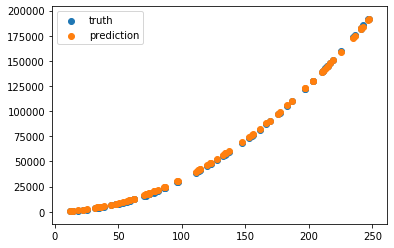

In [22]:
from sympy import sympify
import matplotlib.pyplot as plt
best_solution = hof.items[0]

func = toolbox.compile(expr=best_solution)
y_set = train1['y'].to_numpy()
x_set = train1[train1.columns.difference(['y'])].to_numpy()
features = []
prediction = []
truth = []
# Evaluate the mean squared error between the expression
# and the real function : x**4 + x**3 + x**2 + x
for x,y in zip(x_set, y_set):
    features.append(x)
    prediction.append(func(*x.tolist()))
    truth.append(y)
plt.scatter(features, truth, label='truth')
plt.scatter(features, prediction, label='prediction')
plt.legend()
plt.show()



In [23]:
np_predict = np.array(prediction)
np_truth = np.array(truth)
np.sum((np_predict - np_truth)**2) / len(np_predict)

637905.0529384122

In [15]:
operatorDict = {
    'sub': lambda x, y : x - y,
    'protectedDiv': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'pow': lambda x, y : x**y,
}
expr = sympify(str(best_solution) , locals=operatorDict)
expr = str(expr).replace("neg", "-").replace("_list","_list[i]").replace('ARG0', 'x').replace('**', '^')
expr

'3*x*(x - cos(cos(x + 1) - 1) + 6) + 4*x + (1 - cos(6))*(x^2 + x + 1) + 2'